In [1]:
# implemented using PyTorch 1.0

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import time
import sys
import os

# which GPU
c_dev = 0

In [2]:
with torch.no_grad():
    # set base dir to the directory where the 63 train contrast-enhanced CT scans are located
    base_dir = '/patch/to/your/train_folder/'
    train_img_list = os.listdir(base_dir+'images/')
    train_img_shape = nib.load(base_dir+'images/'+train_img_list[0]).get_data().shape
    len_train_list = len(train_img_list)

In [ ]:
with torch.no_grad():
    # prepare the image tensor that holds all data & normalize the grayvalues
    B = len(train_img_list)
    H = train_img_shape[0]; W = train_img_shape[1]; D = train_img_shape[2];
    img_tensor = torch.zeros(B,1,H,W,D)

    for i in range(B):
        # normalize the image data first!
        img_data_2_normalize = torch.from_numpy(nib.load(base_dir+'images/'+train_img_list[i]).get_data()).contiguous()
        tmp_mean = torch.mean(img_data_2_normalize.view(-1))
        tmp_std = torch.std(img_data_2_normalize.view(-1))
        img_norm = (img_data_2_normalize - tmp_mean) / tmp_std
        img_tensor[i,0,:,:,:] = img_norm
        

-1.5882692337036133
1.1218256950378418
ImgSz: torch.Size([63, 1, 243, 176, 293])


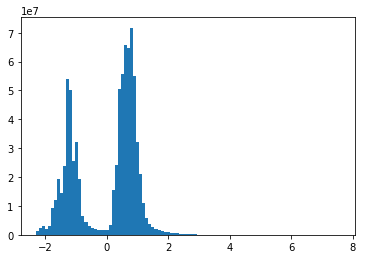

In [4]:
with torch.no_grad():
    #show the grayvalue distribution after normalization
    plt.hist(img_tensor.view(-1).numpy(),bins=100);
    min_plot = np.percentile(img_tensor.view(-1).numpy(),5)
    max_plot = np.percentile(img_tensor.view(-1).numpy(),95)
    print(min_plot)
    print(max_plot)
    print('ImgSz:', img_tensor.size())

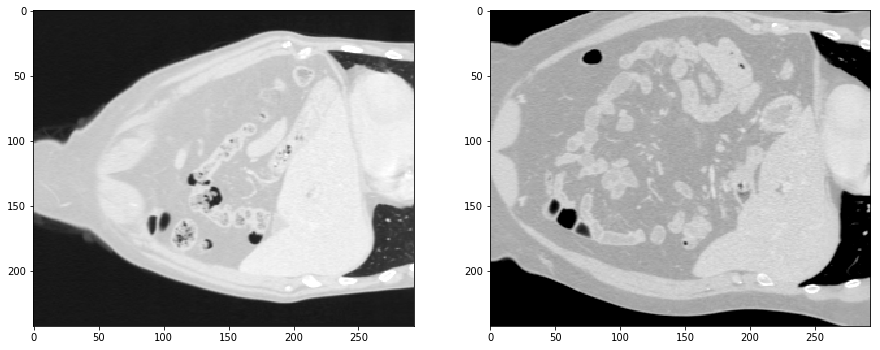

In [5]:
with torch.no_grad():
    #show some exemplare slices for two different patients
    plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.imshow(img_tensor[1,0,:,60,:],cmap='gray', vmin=min_plot, vmax=max_plot)
    plt.subplot(122)
    plt.imshow(img_tensor[3,0,:,60,:],cmap='gray', vmin=min_plot, vmax=max_plot)

In [ ]:
# define some helper functions
def time_str(sec_sum):
    days = int(sec_sum // (24 * 60 * 60))
    sec_left = sec_sum - days * 24 * 60 * 60
    hours = int(sec_left // (60 * 60))
    sec_left = sec_left - hours * 60 * 60
    minutes = int(sec_left // 60)
    seconds = int(sec_left - minutes * 60)
    t_str = 'Time elapsed: {}d'.format(days) + ' {}h'.format(hours) + ' {}m'.format(minutes) + ' {}s'.format(seconds)
    return t_str

def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

def init_weights(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# this function is used to generate the groundtruth heatmap images
# input:
# xdelta -> offset for gauss-blob in x direction
# ydelta -> offset for gauss-blob in y direction
# hsigma -> gauss-sigma
# pwidth -> size of the square output patch
# g0,g1  -> meshgrid to compute the center-distances more easily
def heatmap_gen(xdelta, ydelta, hsigma, pwidth, g0, g1):
    # for broadcast along right dimensions
    xdelta = xdelta.view(-1,1,1,1)
    ydelta = ydelta.view(-1,1,1,1)
    bsz = xdelta.size(0)
    g0.requires_grad = False
    g1.requires_grad = False
    out = (g0 - xdelta)**2 + (g1 - ydelta)**2
    out *= -1
    out *= hsigma.view(bsz,1,1,1).expand(bsz,1,pwidth,pwidth).to(xdelta.device)
    out = 10*torch.exp(out)
    return out

In [3]:
# network and 

# defining the D2D-CNN of the paper used to learn inherent anatomical knowledge just by 
# spatial relations;
# this part will serve as the feature extractor:
# it takes (3,42,42) - (chan,x,y) inputs, meaning: along the current axis, 3 neighboring planes with 
# spatial extensions (42,42) are processed channelwise;
# after being processed by this architecture, the output is of spatial size (1,1) and has 64 channels
            
class ConvNet(nn.Module):
    def __init__(self):
        # takes 3 neighboring slices as channels
        super(ConvNet, self).__init__()
        self.layer1 = nn.Conv2d(3, 32, 3, stride=1, dilation=1, bias=False, groups=1)
        self.mp1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm1 = torch.nn.GroupNorm(4,32)
        self.acti1 = torch.nn.LeakyReLU()
        
        self.layer2 = nn.Conv2d(32, 32, 3, stride=1, dilation=1, bias=False, groups=1)
        self.mp2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm2 = torch.nn.GroupNorm(4,32)
        self.acti2 = torch.nn.LeakyReLU()
        
        self.layer3 = nn.Conv2d(32, 64, 3, stride=1, dilation=1, bias=False, groups=1)
        self.norm3 = torch.nn.GroupNorm(4,64)
        self.acti3 = torch.nn.LeakyReLU()
        
        self.layer4 = nn.Conv2d(64, 64, 3, stride=1, dilation=1, bias=False, groups=1)
        self.norm4 = torch.nn.GroupNorm(4,64)
        self.acti4 = torch.nn.LeakyReLU()
        
        self.layer5 = nn.Conv2d(64, 64, 3, stride=1, dilation=1, bias=False, groups=1)
        self.norm5 = torch.nn.GroupNorm(4,64)
        self.acti5 = torch.nn.LeakyReLU()
        
        self.layer6 = nn.Conv2d(64, 64, 3, stride=1, dilation=1, bias=False, groups=1)
        self.norm6 = torch.nn.GroupNorm(4,64)
        self.acti6 = torch.nn.LeakyReLU()
        
    def forward(self, patches):
        x = self.acti1(self.norm1(self.mp1(self.layer1(patches))))
        x = self.acti2(self.norm2(self.mp2(self.layer2(x))))
        x = self.acti3(self.norm3(self.layer3(x)))
        x = self.acti4(self.norm4(self.layer4(x)))
        x = self.acti5(self.norm5(self.layer5(x)))
        x = self.acti6(self.norm6(self.layer6(x)))
        x_feat = x
        return x_feat


# this CNN is used during training, when we apply our proposed trainig scheme;
# i.e. in a siamese-fashion, we process two patches with the D2D-CNN above to
# generate feature decriptors for these patches and subsequently, we pass both
# descriptors to this "HeatNet"; here, from the concatenated feature representations
# of size (128,1,1) this network will be trained to retrieve a spatial heatmap
# of size (1,19,19) -> the groundtruth is generated with the function "heatmap_gen" defined above
class HeatNet(nn.Module):
    def __init__(self):

        super(HeatNet, self).__init__()
        self.layer1 = nn.Conv2d(128, 64, 1, bias=False, groups=1)
        self.norm1 = torch.nn.GroupNorm(4,64)
        self.acti1 = torch.nn.LeakyReLU()
        
        self.layer2 = nn.Conv2d(64, 32, 1, bias=False, groups=1)
        self.norm2 = torch.nn.GroupNorm(4,32)
        self.acti2 = torch.nn.LeakyReLU()
        
        self.layer2_a = nn.Conv2d(32, 16, 1, bias=False, groups=1)
        self.norm2_a = torch.nn.GroupNorm(4,16)
        self.acti2_a = torch.nn.LeakyReLU()
        
        self.layer3_0 = nn.ConvTranspose2d(16, 16, 5, bias=False, groups=1)
        self.norm3_0 = torch.nn.GroupNorm(4,16)
        self.acti3_0 = torch.nn.LeakyReLU()
        self.layer3_1 = nn.Conv2d(16, 16, 3, bias=False, groups=1)
        self.norm3_1 = nn.BatchNorm2d(16)
        self.acti3_1 = torch.nn.LeakyReLU()
        
        self.layer4_0 = nn.ConvTranspose2d(16, 16, 5, bias=False, groups=1)
        self.norm4_0 = torch.nn.GroupNorm(4,16)
        self.acti4_0 = torch.nn.LeakyReLU()
        self.layer4_1 = nn.Conv2d(16, 8, 3, bias=False, groups=1)
        self.norm4_1 = nn.BatchNorm2d(8)
        self.acti4_1 = torch.nn.LeakyReLU()
        
        self.layer5_0 = nn.ConvTranspose2d(8, 4, 5, bias=False, groups=1)
        self.norm5_0 = torch.nn.GroupNorm(4,4)
        self.acti5_0 = torch.nn.LeakyReLU()
        self.layer5_1 = nn.Conv2d(4, 1, 3, padding=1, groups=1)

    def forward(self, x_feat1, x_feat2):

        x = self.acti1(self.norm1(self.layer1(torch.cat((x_feat1,x_feat2),1))))
        x = self.acti2(self.norm2(self.layer2(x)))
        x = self.acti2_a(self.norm2_a(self.layer2_a(x)))
        
        x = self.acti3_0(self.norm3_0(self.layer3_0(x)))
        x = self.acti3_1(self.norm3_1(self.layer3_1(x)))
        
        x = F.interpolate(x,size=(11,11),mode='bilinear',align_corners=True)
        
        x = self.acti4_0(self.norm4_0(self.layer4_0(x)))
        x = F.avg_pool2d(self.acti4_1(self.norm4_1(self.layer4_1(x))),3,padding=1,stride=1)

        x = self.acti5_0(self.norm5_0(self.layer5_0(x)))
        
        x = F.interpolate(x,size=(19,19),mode='bilinear',align_corners=True)
        
        heatmap = self.layer5_1(x)
        return heatmap
    
# this CNN is used during training, when we apply our proposed trainig scheme;
# i.e. in a siamese-fashion, we process two patches with the D2D-CNN above to
# generate feature decriptors for these patches and subsequently, we pass both
# descriptors to this "OffNet"; here, from the concatenated feature representations
# of size (128,1,1) this network will be trained to just output the two offset parameters
# that define the inplane displacement in contrast to the spatial reconstruction of the 
# HeatMap approach
class OffNet(nn.Module):
    def __init__(self):

        super(OffNet, self).__init__()
        self.layer1 = nn.Conv2d(128, 128, 1, bias=False, groups=1)
        self.norm1 = torch.nn.GroupNorm(4,128)
        self.acti1 = torch.nn.LeakyReLU()
        
        self.layer2 = nn.Conv2d(128, 64, 1, bias=False, groups=1)
        self.norm2 = torch.nn.GroupNorm(4,64)
        self.acti2 = torch.nn.LeakyReLU()
        
        self.layer3 = nn.Conv2d(64, 32, 1, bias=False, groups=1)
        self.norm3 = torch.nn.GroupNorm(4,32)
        self.acti3 = torch.nn.LeakyReLU()
        
        self.layer_out = nn.Conv2d(32, 2, 1, groups=1)

    def forward(self, x_feat1, x_feat2):

        x = self.acti1(self.norm1(self.layer1(torch.cat((x_feat1,x_feat2),1))))
        x = self.acti2(self.norm2(self.layer2(x)))
        x = self.acti3(self.norm3(self.layer3(x)))
        
        off_pred = self.layer_out(x)
        return off_pred
    
# this CNN is the descriptor part of the 3D extended Doersch approach;
# cubes of inputsize (25,25,25) will be turned into descriptors of size 1^3
# and 192 channels
class DoerschNet(nn.Module):
    def __init__(self):

        super(DoerschNet, self).__init__()
        self.layer1 = nn.Conv3d(1, 16, 5, bias=False, groups=1)
        self.norm1 = torch.nn.GroupNorm(4,16)
        self.acti1 = torch.nn.LeakyReLU()
        
        self.layer2 = nn.Conv3d(16, 32, 3, dilation=2, bias=False, groups=1)
        self.norm2 = torch.nn.GroupNorm(4,32)
        self.acti2 = torch.nn.LeakyReLU()
        
        self.layer3 = nn.Conv3d(32, 32, 3, dilation=2, bias=False, groups=1)
        self.norm3 = torch.nn.GroupNorm(4,32)
        self.acti3 = torch.nn.LeakyReLU()
        
        self.layer4 = nn.Conv3d(32, 32, 3, dilation=2, bias=False, groups=1)
        self.norm4 = torch.nn.GroupNorm(4,32)
        self.acti4 = torch.nn.LeakyReLU()
        
        self.layer5 = nn.Conv3d(32, 32, 3, dilation=1, bias=False, groups=1)
        self.norm5 = torch.nn.GroupNorm(4,32)
        self.acti5 = torch.nn.LeakyReLU()
        
        self.layer6 = nn.Conv3d(32, 32, 5, bias=False, groups=1)
        self.norm6 = torch.nn.GroupNorm(4,32)
        self.acti6 = torch.nn.LeakyReLU()
        
        self.layer7 = nn.Conv3d(32, 3*64, 3, bias=False, groups=1)
        self.norm7 = torch.nn.GroupNorm(4,3*64)
        self.acti7 = torch.nn.LeakyReLU()
        

    def forward(self, x):

        x = self.acti1(self.norm1(self.layer1(x)))
        x = self.acti2(self.norm2(self.layer2(x)))
        x = self.acti3(self.norm3(self.layer3(x)))
        x = self.acti4(self.norm4(self.layer4(x)))
        x = self.acti5(self.norm5(self.layer5(x)))
        x = self.acti6(self.norm6(self.layer6(x)))
        x = self.acti7(self.norm7(self.layer7(x)))
        
        return x
       
# similar to the offset parameter regression approach, this decoder part also
# takes as input two feature encodings by the DoerschCNN in a siamese manner.
# here, the auxiliary task is a classification problem instead of a regression task;
# the output encodes the relative position of encoding1 with respect to encoding2
# (top/bottom, left/right, front/back)
class DoerschDecodeNet(nn.Module):
    def __init__(self):

        super(DoerschDecodeNet, self).__init__()
        self.layer1 = nn.Conv3d(2*3*64, 64, 1, bias=False, groups=1)
        self.norm1 = torch.nn.GroupNorm(4,64)
        self.acti1 = torch.nn.LeakyReLU()
        
        self.layer2 = nn.Conv3d(64, 64, 1, bias=False, groups=1)
        self.norm2 = torch.nn.GroupNorm(4,64)
        self.acti2 = torch.nn.LeakyReLU()
        
        self.layer3 = nn.Conv3d(64, 32, 1, bias=False, groups=1)
        self.norm3 = torch.nn.GroupNorm(4,32)
        self.acti3 = torch.nn.LeakyReLU()
        
        self.layer_out = nn.Conv3d(32, 6, 1, groups=1)

    def forward(self, x_feat1, x_feat2):

        x = self.acti1(self.norm1(self.layer1(torch.cat((x_feat1,x_feat2),1))))
        x = self.acti2(self.norm2(self.layer2(x)))
        x = self.acti3(self.norm3(self.layer3(x)))
        
        neighbor_pred = self.layer_out(x)
        return neighbor_pred

In [4]:
# here we check all above defined CNNs for their parameter count
# count(DNet) should roughly be comparable to 3*count(CNet), since we use a CNet for
# every axis and concatenate their descriptor output for 1 position;
# also count(NNet), count(HNet) and count(ONet) should be similar for being the additional,
# auxiliary task-dependent network parts
DNet = DoerschNet()
NNet = DoerschDecodeNet()
CNet = ConvNet()
HNet = HeatNet()
ONet = OffNet()

print('DNet #:', countParameters(DNet))
print('CNet #:', countParameters(CNet))
print('NNet #:', countParameters(NNet))
print('HNet #:', countParameters(HNet))
print('ONet #:', countParameters(ONet))

xxx = torch.randn(1,1,25,25,25)
yyy = DNet(xxx)
print(yyy.size())

del DNet, CNet, NNet, HNet, ONet

DNet #: 393392
CNet #: 139744
NNet #: 31238
HNet #: 28189
ONet #: 27138
torch.Size([1, 192, 1, 1, 1])


In [9]:
# definition of basic learning parameters
with torch.no_grad():
    with torch.cuda.device(c_dev):
        rnd_perm_pats = torch.randperm(img_tensor.size(0))
        train_sz = 63
        train_pats = torch.arange(train_sz)
        print('Train_Patients:', train_pats)
        nr_epochs = int(8*1e5)#!!!
        batch_sz = 8
        opti_lr = 5e-5

Train_Patients: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62])


DNet # params:  393392
NNet # params:  31238
Time elapsed: 0d 7h 52m 32s


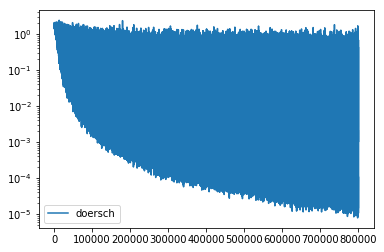

In [10]:
# recreate the training;
############################################################################
# train a descriptor CNN based on the 3D extension of the Doersch approach
############################################################################
with torch.enable_grad():
    with torch.cuda.device(c_dev):
        DNet = DoerschNet().cuda().apply(init_weights)
        NNet = DoerschDecodeNet().cuda().apply(init_weights)
        print('DNet # params: ', countParameters(DNet))
        print('NNet # params: ', countParameters(NNet))
        
        # how far from the image center is  patch1 sampling allowed
        zero_off = 0.5
        
        patch_width_d = 25
        
        metric = nn.CrossEntropyLoss()
        
        adam = optim.Adam([
                {'params': DNet.parameters(), 'lr': opti_lr},
                {'params': NNet.parameters(), 'lr': opti_lr}
                ])
        
        DNet.train()
        NNet.train()
        
        loss_evo_doersch = torch.zeros(nr_epochs)
        
        # prepare the meshgrid needed to sample the 25^3 cubes that will be passed to
        # the DNet as input
        m_l = torch.linspace(-0.2,0.2,25)
        m0,m1,m2 = torch.meshgrid(m_l,m_l,m_l)
        patch_012 = torch.stack((m2,m1,m0),3).unsqueeze(0).view(1,1,-1,1,3)
        # expand the meshgrid for patch extraction to batch-size (expand: without allocating new memory)
        patch_012 = patch_012.expand(batch_sz,-1,-1,-1,-1).cuda()
        
        start_train_time = time.time()
        for epx in range(nr_epochs):
            
            # generate random batch of patients
            if epx % 25 == 0:
                pat_batch = train_pats[torch.randperm(batch_sz)%train_sz][0:batch_sz]
                crnt_pat_batch_imgs = img_tensor[pat_batch,...].cuda()
            
            if epx % 1 == 0:
                
                # randomly uniform displacements for batch_sz centers to extract patches
                patch_centers_1 = torch.zeros(batch_sz,1,1,1,3).uniform_(-zero_off,zero_off).expand_as(patch_012).cuda()
                
                patches_1 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_012)

                # randomly generate displacements from patch_centers_1 (at least 0.25 apart 
                # in one of the axis directions + jitter to prevent learning simple line continuation hints
                
                patch_center_offsets = torch.zeros(batch_sz,3)
                # draw per batch the axis for the neighboring volume 0/1/2
                axis_vec = torch.randint(low=0,high=3,size=(1,batch_sz))
                # draw per batch if the volume sits before/behind the center at these axes
                pm_vec = torch.randint(low=0,high=2,size=(1,batch_sz))
                # construct 6 classes from it
                goal_vec = axis_vec*2 + pm_vec
                # construct the vector that has to be added to the base_vec (per row, for specified column)
                add_vec = (0.45*torch.ones(batch_sz).view(1,batch_sz)) * (-1.0)**(pm_vec.float())
                # add it...
                patch_center_offsets[torch.arange(batch_sz),axis_vec] += add_vec

                patch_center_offsets = patch_center_offsets.cuda().view(batch_sz,1,1,1,3)
                patches_2 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_012 + patch_center_offsets)

                # generate 3D view of extracted patches -> dimension 1 should be interpreted as channels
                patches_1 = patches_1.view(batch_sz,1,patch_width_d,patch_width_d,patch_width_d)
                patches_2 = patches_2.view(batch_sz,1,patch_width_d,patch_width_d,patch_width_d)
            
            patches_1 = patches_1.detach()
            patches_2 = patches_2.detach()
            goal_vec = goal_vec.detach()
            
            adam.zero_grad()
            # send the patches through the feature learning network
            feat_1 = DNet(patches_1)
            feat_2 = DNet(patches_2)
            
            # send them through the neighbor learning network
            pred_neigh = NNet(feat_1, feat_2)
            loss = metric(pred_neigh.view(batch_sz,6), goal_vec.view(-1).cuda())
            
            loss.backward()
            adam.step()
            
            loss_evo_doersch[epx] = loss.item()
            
end_train_time = time.time()

print(time_str(end_train_time - start_train_time))


plt.figure()
plt.semilogy(loss_evo_doersch.numpy(),label='doersch')
plt.legend()

# clearing gpu memory
del patch_012
del crnt_pat_batch_imgs
del patch_centers_1
del patch_center_offsets
del feat_1, feat_2
del loss
del adam
del NNet
torch.cuda.empty_cache()

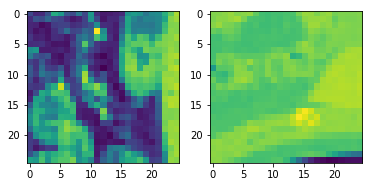

In [11]:
# visualize a slice through a pair of cubes whose relation has to be predicted by the network

plt.figure()
plt.subplot(121)
plt.imshow(patches_1[1,0,:,12,:].cpu().detach())
plt.subplot(122)
plt.imshow(patches_2[1,0,:,12,:].cpu().detach())
del patches_1, patches_2
del goal_vec
del pred_neigh
torch.cuda.empty_cache()

CNet # params:  139744
HNet # params:  28189
ONet # params:  27138
Time elapsed: 0d 5h 32m 14s
pred
[[-0.13225158 -0.1747983 ]
 [ 0.3268657   0.4734372 ]
 [-0.4187293  -0.48259503]
 [ 0.24721278  0.18224715]
 [ 0.3302487  -0.05129373]
 [-0.48509884  0.52551216]
 [ 0.3133762   0.23561685]
 [-0.3335475   0.5983597 ]]
gt
[[-0.13052647 -0.18149075]
 [ 0.36606705  0.48848158]
 [-0.46095026 -0.50211066]
 [ 0.2650386   0.19220711]
 [ 0.3320577  -0.03880475]
 [-0.5803897   0.46906763]
 [ 0.3091282   0.23615846]
 [-0.31985483  0.65221214]]


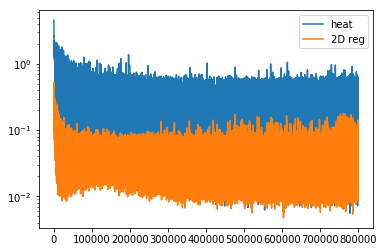

In [12]:
# recreate the training
#################################################################################
# train a descriptor CNNs based on both types of regression tasks:
# 1) heatmap and 2) direct 2 parameter regression;
# for a fair comparison, both CNNs will be trained on the exact same patch pairs
# I) first axis of 3
#################################################################################
with torch.enable_grad():
    with torch.cuda.device(c_dev):
        CNet0 = ConvNet().cuda().apply(init_weights)
        CNet0_off = ConvNet().cuda().apply(init_weights)
        HNet = HeatNet().cuda().apply(init_weights)
        ONet = OffNet().cuda().apply(init_weights)
        print('CNet # params: ', countParameters(CNet0))
        print('HNet # params: ', countParameters(HNet))
        print('ONet # params: ', countParameters(ONet))
        
        
        # how far from the middle is  patch1 sampling allowed
        zero_off = 0.3
        
        # for displacement between center patches1 and patches2 in axis1 direction!
        min_off0 = 0.125 #0.03
        max_off0 = 0.25 #0.15
        
        patch_width = 42
        heatmap_width = 19
        
        metric = nn.MSELoss()#nn.MSELoss()
        metric_off = nn.L1Loss()
        #adam = optim.Adam(list(CNet.parameters())+list(HNet.parameters()),lr=0.0001)
        
        adam = optim.Adam([
                {'params': CNet0.parameters(), 'lr': opti_lr},
                {'params': HNet.parameters(), 'lr': opti_lr}
                ])
        adam_off = optim.Adam([
                {'params': CNet0_off.parameters(), 'lr': opti_lr},
                {'params': ONet.parameters(), 'lr': opti_lr}
                ])
        
        # for displacement between center patches1 and patches2 in axis0/2 direction!
        displ_vec_min = torch.linspace(0.25, 0.0, nr_epochs)
        displ_vec_max = torch.linspace(0.3, 0.7, nr_epochs)
        
        sigma_vec = torch.linspace(15, 15, nr_epochs)
        
        CNet0.train()
        CNet0_off.train()
        HNet.train()
        ONet.train()
        
        #img_tensor = img_tensor.cuda()
        
        loss_evo_0 = torch.zeros(nr_epochs)
        loss_evo_off_0 = torch.zeros(nr_epochs)
        
        # generate patch extraction grid for dimensions 0,2
        m_s = torch.linspace(-0.05,0.05,3)
        m_l = torch.linspace(-0.4,0.4,42)
        m0,m1,m2 = torch.meshgrid(m_s,m_l,m_l)
        patch_12 = torch.stack((m2,m1,m0),3).unsqueeze(0).view(1,1,-1,1,3)
        # expand the meshgrid for patch extraction to batch-size (expand: without allocating new memory)
        patch_12 = patch_12.expand(batch_sz,-1,-1,-1,-1).cuda()
        
        
        tmp_m1p1 = torch.linspace(-1,1,heatmap_width)
        g1,g0 = torch.meshgrid(tmp_m1p1,tmp_m1p1)
        g0 = g0.unsqueeze(0).unsqueeze(0).expand(batch_sz,1,heatmap_width,heatmap_width).cuda()
        g1 = g1.unsqueeze(0).unsqueeze(0).expand(batch_sz,1,heatmap_width,heatmap_width).cuda()
        
        
        start_train_time = time.time()
        for epx in range(nr_epochs):
            
            # set the 02 direction max value for displacements between the patch centers
            min_off12 = displ_vec_min[epx]
            max_off12 = displ_vec_max[epx]
            
            # generate random batch of patients
            if epx % 25 == 0:
                pat_batch = train_pats[torch.randperm(batch_sz)%train_sz][0:batch_sz]
                crnt_pat_batch_imgs = img_tensor[pat_batch,...].cuda()
            
            if epx % 1 == 0:
                
                # randomly uniform displacements for batch_sz centers to extract patches
                patch_centers_1 = torch.zeros(batch_sz,1,1,1,3).uniform_(-zero_off,zero_off).expand_as(patch_12).cuda()
                
                patches_1 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_12)

                # randomly generate displacements from patch_centers_1 (at least 0.03 apart in dim 0 to 
                # prevent overlaps with the extracted volumes_1) and use displacements in direction 0/2 
                # to generate the heatmaps that should be learned/reproduced as an auxiliary task in HNet
                # based on the learned features from CNet

                patch_center_offsets = torch.zeros(batch_sz,3)
                # at dim1: at least 0.03 away to not interfere with other volumes; and randomly before/behind
                # along this axis
                patch_center_offsets[:,0] = torch.zeros(batch_sz).uniform_(min_off0,max_off0) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                patch_center_offsets[:,1] = torch.zeros(batch_sz).uniform_(min_off12,max_off12) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                patch_center_offsets[:,2] = torch.zeros(batch_sz).uniform_(min_off12,max_off12) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                
                patch_center_offsets = patch_center_offsets.cuda().view(batch_sz,1,1,1,3)
                patches_2 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_12 + patch_center_offsets)

                # generate the corresponding heatmaps based on the patch_center_offsets in dimensions 0/2
                heat_goal = heatmap_gen(patch_center_offsets[:,0,0,0,1], 
                                        patch_center_offsets[:,0,0,0,2],
                                        sigma_vec[epx]*torch.ones(batch_sz), 
                                        heatmap_width,
                                        g0, g1)

                # generate 2D view of extracted patches -> dimension 1 should be interpreted as channels
                patches_1 = patches_1.view(batch_sz,3,patch_width,patch_width)
                patches_2 = patches_2.view(batch_sz,3,patch_width,patch_width)
            
            patches_1 = patches_1.detach()
            patches_2 = patches_2.detach()
            heat_goal = heat_goal.detach()
            
            adam.zero_grad()
            adam_off.zero_grad()
            # send the patches through the feature learning network (permute )
            feat_1 = CNet0(patches_1)
            feat_2 = CNet0(patches_2)
            
            feat_1_off = CNet0_off(patches_1)
            feat_2_off = CNet0_off(patches_2)
            
            # send them through the heatmap learning network
            pred_heat = HNet(feat_1, feat_2)
            pred_heat_off = ONet(feat_1_off, feat_2_off)
            loss = metric(pred_heat, heat_goal) 
            loss_off = metric_off(pred_heat_off.view(-1,2), patch_center_offsets[:,0,0,0,1:].view(-1,2))
            
            loss.backward()
            adam.step()
            loss_off.backward()
            adam_off.step()
            
            loss_evo_0[epx] = loss.item()
            loss_evo_off_0[epx] = loss_off.item()
            
end_train_time = time.time()

print(time_str(end_train_time - start_train_time))
print('pred')
print(pred_heat_off.view(-1,2).detach().cpu().numpy())
print('gt')
print(patch_center_offsets[:,0,0,0,1:].view(-1,2).detach().cpu().numpy())

plt.figure()
plt.semilogy(loss_evo_0.numpy(),label='heat')
plt.semilogy(loss_evo_off_0.numpy(),label='2D reg')
plt.legend()
# clearing gpu memory
del patch_12
del g0, g1
del crnt_pat_batch_imgs
del patch_centers_1
del patch_center_offsets
del feat_1, feat_2, feat_1_off, feat_2_off
del loss, loss_off
del adam, adam_off
del HNet, ONet
torch.cuda.empty_cache()

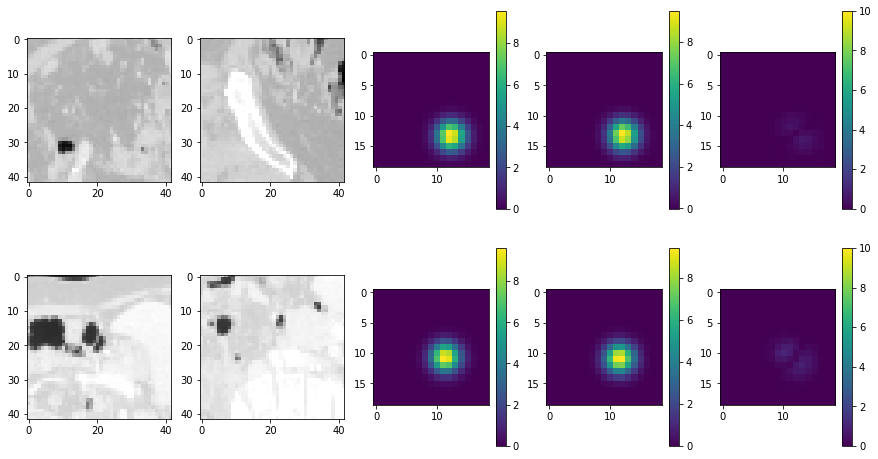

In [13]:
# visualize training
patches_vis_1 = patches_1.cpu().detach()
patches_vis_2 = patches_2.cpu().detach()

show_1 = 1
show_2 = 3

plt.figure(figsize=(15,8))
plt.subplot(251)
plt.imshow(patches_vis_1[show_1,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(252)
plt.imshow(patches_vis_2[show_1,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(253)
plt.imshow(heat_goal.cpu()[show_1,0,:,:])
plt.colorbar()
plt.subplot(254)
plt.imshow(pred_heat.detach().cpu()[show_1,0,:,:])
plt.colorbar()
plt.subplot(255)
plt.imshow(torch.abs(heat_goal.cpu()-pred_heat.detach().cpu())[show_1,0,:,:], vmin=0.0, vmax=10.0)
plt.colorbar()
plt.subplot(256)
plt.imshow(patches_vis_1[show_2,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(257)
plt.imshow(patches_vis_2[show_2,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(258)
plt.imshow(heat_goal.cpu()[show_2,0,:,:])
plt.colorbar()
plt.subplot(259)
plt.imshow(pred_heat.detach().cpu()[show_2,0,:,:])
plt.colorbar()
plt.subplot(2,5,10)
plt.imshow(torch.abs(heat_goal.cpu()-pred_heat.detach().cpu())[show_2,0,:,:], vmin=0.0, vmax=10.0)
plt.colorbar()


In [14]:
del patches_1, patches_2
del heat_goal
del pred_heat
torch.cuda.empty_cache()

CNet # params:  139744
HNet # params:  28189
ONet # params:  27138
Time elapsed: 0d 5h 35m 11s


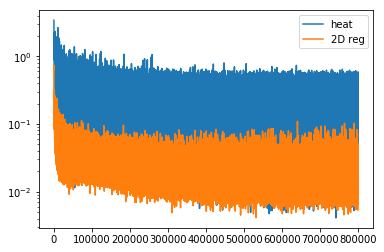

In [15]:
# recreate the training
#################################################################################
# train a descriptor CNNs based on both types of regression tasks:
# 1) heatmap and 2) direct 2 parameter regression;
# for a fair comparison, both CNNs will be trained on the exact same patch pairs
# II) second axis of 3
#################################################################################
with torch.enable_grad():
    with torch.cuda.device(c_dev):
        CNet1 = ConvNet().cuda().apply(init_weights)
        CNet1_off = ConvNet().cuda().apply(init_weights)
        HNet = HeatNet().cuda().apply(init_weights)
        ONet = OffNet().cuda().apply(init_weights)
        print('CNet # params: ', countParameters(CNet1))
        print('HNet # params: ', countParameters(HNet))
        print('ONet # params: ', countParameters(ONet))

        
        # how far from the middle is  patch1 sampling allowed
        zero_off = 0.3
        
        # for displacement between center patches1 and patches2 in axis1 direction!
        min_off1 = 0.125 #0.03
        max_off1 = 0.25 #0.15
        
        patch_width = 42
        heatmap_width = 19
        
        metric = nn.MSELoss()#nn.MSELoss()
        metric_off = nn.L1Loss()
        
        #adam = optim.Adam(list(CNet.parameters())+list(HNet.parameters()),lr=0.0001)
        
        adam = optim.Adam([
                {'params': CNet1.parameters(), 'lr': opti_lr},
                {'params': HNet.parameters(), 'lr': opti_lr}
                ])
        adam_off = optim.Adam([
                {'params': CNet1_off.parameters(), 'lr': opti_lr},
                {'params': ONet.parameters(), 'lr': opti_lr}
                ])
        # for displacement between center patches1 and patches2 in axis0/2 direction!
        displ_vec_min = torch.linspace(0.25, 0.0, nr_epochs)
        displ_vec_max = torch.linspace(0.3, 0.7, nr_epochs)
        
        sigma_vec = torch.linspace(15, 15, nr_epochs)
        
        CNet1.train()
        CNet1_off.train()
        HNet.train()
        ONet.train()
        
        #img_tensor = img_tensor.cuda()
        
        loss_evo_1 = torch.zeros(nr_epochs)
        loss_evo_off_1 = torch.zeros(nr_epochs)
        # generate patch extraction grid for dimensions 0,2
        m_s = torch.linspace(-0.05,0.05,3)
        m_l = torch.linspace(-0.4,0.4,42)
        m0,m1,m2 = torch.meshgrid(m_l,m_s,m_l)
        patch_02 = torch.stack((m2,m1,m0),3).unsqueeze(0).view(1,1,-1,1,3)
        # expand the meshgrid for patch extraction to batch-size (expand: without allocating new memory)
        patch_02 = patch_02.expand(batch_sz,-1,-1,-1,-1).cuda()
        
        tmp_m1p1 = torch.linspace(-1,1,heatmap_width)
        g1,g0 = torch.meshgrid(tmp_m1p1,tmp_m1p1)
        g0 = g0.unsqueeze(0).unsqueeze(0).expand(batch_sz,1,heatmap_width,heatmap_width).cuda()
        g1 = g1.unsqueeze(0).unsqueeze(0).expand(batch_sz,1,heatmap_width,heatmap_width).cuda()
        
        
        start_train_time = time.time()
        for epx in range(nr_epochs):
            
            # set the 02 direction max value for displacements between the patch centers
            min_off02 = displ_vec_min[epx]
            max_off02 = displ_vec_max[epx]
            
            # generate random batch of patients
            if epx % 25 == 0:
                pat_batch = train_pats[torch.randperm(batch_sz)%train_sz][0:batch_sz]
                crnt_pat_batch_imgs = img_tensor[pat_batch,...].cuda()
            
            if epx % 1 == 0:
                
                # randomly uniform displacements for batch_sz centers to extract patches
                patch_centers_1 = torch.zeros(batch_sz,1,1,1,3).uniform_(-zero_off,zero_off).expand_as(patch_02).cuda()
                
                patches_1 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_02)

                # randomly generate displacements from patch_centers_1 (at least 0.03 apart in dim 0 to 
                # prevent overlaps with the extracted volumes_1) and use displacements in direction 0/2 
                # to generate the heatmaps that should be learned/reproduced as an auxiliary task in HNet
                # based on the learned features from CNet

                patch_center_offsets = torch.zeros(batch_sz,3)
                # at dim1: at least 0.03 away to not interfere with other volumes; and randomly before/behind
                # along this axis
                patch_center_offsets[:,1] = torch.zeros(batch_sz).uniform_(min_off1,max_off1) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                patch_center_offsets[:,0] = torch.zeros(batch_sz).uniform_(min_off02,max_off02) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                patch_center_offsets[:,2] = torch.zeros(batch_sz).uniform_(min_off02,max_off02) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                
                patch_center_offsets = patch_center_offsets.cuda().view(batch_sz,1,1,1,3)
                patches_2 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_02 + patch_center_offsets)

                # generate the corresponding heatmaps based on the patch_center_offsets in dimensions 0/2
                heat_goal = heatmap_gen(patch_center_offsets[:,0,0,0,0],# / (max_off02*2), 
                                        patch_center_offsets[:,0,0,0,2],# / (max_off02*2), 
                                        sigma_vec[epx]*torch.ones(batch_sz), 
                                        heatmap_width,
                                        g0, g1)

                # generate 2D view of extracted patches -> dimension 1 should be interpreted as channels
                patches_1 = patches_1.view(batch_sz,patch_width,3,patch_width).permute(0,2,1,3)
                patches_2 = patches_2.view(batch_sz,patch_width,3,patch_width).permute(0,2,1,3)
            
            patches_1 = patches_1.detach()
            patches_2 = patches_2.detach()
            heat_goal = heat_goal.detach()
            
            adam.zero_grad()
            adam_off.zero_grad()
            # send the patches through the feature learning network (permute )
            feat_1 = CNet1(patches_1)
            feat_2 = CNet1(patches_2)
            
            feat_1_off = CNet1_off(patches_1)
            feat_2_off = CNet1_off(patches_2)
            
            # send them through the heatmap learning network
            pred_heat = HNet(feat_1, feat_2)
            pred_heat_off = ONet(feat_1_off, feat_2_off)
            loss = metric(pred_heat, heat_goal) #+ torch.sum(torch.abs(pred_heat**2))/pred_heat.numel()          
            #print(pred_heat_off.size())
            #print(patch_center_offsets[:,0,0,0,1:])
            loss_off = metric_off(pred_heat_off.view(-1,2), patch_center_offsets[:,0,0,0,1:].view(-1,2))
            
            loss.backward()
            adam.step()
            loss_off.backward()
            adam_off.step()
            
            loss_evo_1[epx] = loss.item()
            loss_evo_off_1[epx] = loss_off.item()
            
end_train_time = time.time()

print(time_str(end_train_time - start_train_time))
            
plt.figure()
#plt.plot(loss_evo.numpy(),label='heat')
#plt.plot(loss_evo_off.numpy(),label='2D reg')
plt.semilogy(loss_evo_1.numpy(),label='heat')
plt.semilogy(loss_evo_off_1.numpy(),label='2D reg')
plt.legend()
# clearing gpu memory
del patch_02
del g0, g1
del crnt_pat_batch_imgs
del patch_centers_1
del patch_center_offsets
del feat_1, feat_2, feat_1_off, feat_2_off
del loss, loss_off
del adam, adam_off
del HNet, ONet
torch.cuda.empty_cache()

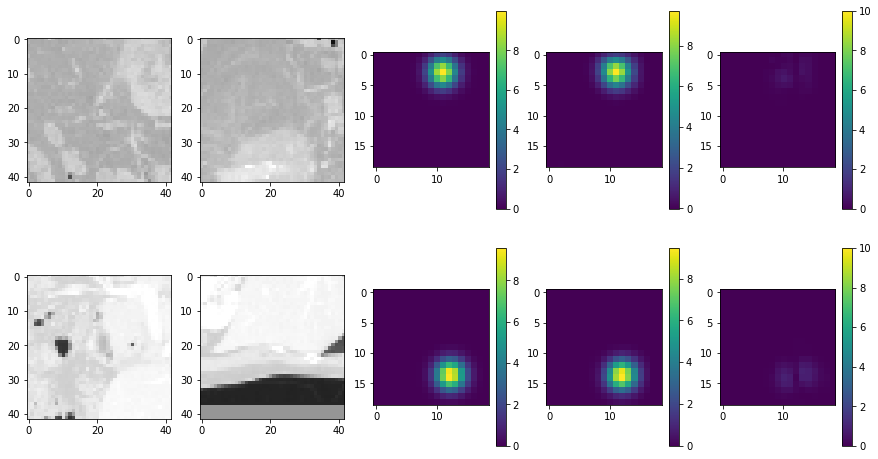

In [16]:
# visualize training
patches_vis_1 = patches_1.cpu().detach()
patches_vis_2 = patches_2.cpu().detach()

show_1 = 1
show_2 = 3

plt.figure(figsize=(15,8))
plt.subplot(251)
plt.imshow(patches_vis_1[show_1,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(252)
plt.imshow(patches_vis_2[show_1,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(253)
plt.imshow(heat_goal.cpu()[show_1,0,:,:])
plt.colorbar()
plt.subplot(254)
plt.imshow(pred_heat.detach().cpu()[show_1,0,:,:])
plt.colorbar()
plt.subplot(255)
plt.imshow(torch.abs(heat_goal.cpu()-pred_heat.detach().cpu())[show_1,0,:,:], vmin=0.0, vmax=10.0)
plt.colorbar()
plt.subplot(256)
plt.imshow(patches_vis_1[show_2,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(257)
plt.imshow(patches_vis_2[show_2,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(258)
plt.imshow(heat_goal.cpu()[show_2,0,:,:])
plt.colorbar()
plt.subplot(259)
plt.imshow(pred_heat.detach().cpu()[show_2,0,:,:])
plt.colorbar()
plt.subplot(2,5,10)
plt.imshow(torch.abs(heat_goal.cpu()-pred_heat.detach().cpu())[show_2,0,:,:], vmin=0.0, vmax=10.0)
plt.colorbar()


In [17]:
del patches_1, patches_2
del heat_goal
del pred_heat
torch.cuda.empty_cache()

In [ ]:
# recreate the training
#################################################################################
# train a descriptor CNNs based on both types of regression tasks:
# 1) heatmap and 2) direct 2 parameter regression;
# for a fair comparison, both CNNs will be trained on the exact same patch pairs
# II) third axis of 3
#################################################################################
with torch.enable_grad():
    with torch.cuda.device(c_dev):
        CNet2 = ConvNet().cuda().apply(init_weights)
        CNet2_off = ConvNet().cuda().apply(init_weights)
        HNet = HeatNet().cuda().apply(init_weights)
        ONet = OffNet().cuda().apply(init_weights)
        print('CNet # params: ', countParameters(CNet2))
        print('HNet # params: ', countParameters(HNet))
        print('ONet # params: ', countParameters(ONet))

        
        # how far from the middle is  patch1 sampling allowed
        zero_off = 0.3
        
        # for displacement between center patches1 and patches2 in axis1 direction!
        min_off2 = 0.125 #0.03
        max_off2 = 0.25 #0.15
        
        patch_width = 42
        heatmap_width = 19
        
        metric = nn.MSELoss()#nn.MSELoss()
        metric_off = nn.L1Loss()
        
        
        adam = optim.Adam([
                {'params': CNet2.parameters(), 'lr': opti_lr},
                {'params': HNet.parameters(), 'lr': opti_lr}
                ])
        adam_off = optim.Adam([
                {'params': CNet2_off.parameters(), 'lr': opti_lr},
                {'params': ONet.parameters(), 'lr': opti_lr}
                ])
        # for displacement between center patches1 and patches2 in axis0/2 direction!
        displ_vec_min = torch.linspace(0.25, 0.0, nr_epochs)
        displ_vec_max = torch.linspace(0.3, 0.7, nr_epochs)
        
        sigma_vec = torch.linspace(15, 15, nr_epochs)
        
        CNet2.train()
        CNet2_off.train()
        HNet.train()
        ONet.train()
        
        #img_tensor = img_tensor.cuda()
        
        loss_evo_2 = torch.zeros(nr_epochs)
        loss_evo_off_2 = torch.zeros(nr_epochs)
        
        # generate patch extraction grid for dimensions 0,2
        m_s = torch.linspace(-0.05,0.05,3)
        m_l = torch.linspace(-0.4,0.4,42)
        m0,m1,m2 = torch.meshgrid(m_l,m_l,m_s)
        patch_01 = torch.stack((m2,m1,m0),3).unsqueeze(0).view(1,1,-1,1,3)
        # expand the meshgrid for patch extraction to batch-size (expand: without allocating new memory)
        patch_01 = patch_01.expand(batch_sz,-1,-1,-1,-1).cuda()
        
        
        tmp_m1p1 = torch.linspace(-1,1,heatmap_width)
        g1,g0 = torch.meshgrid(tmp_m1p1,tmp_m1p1)
        g0 = g0.unsqueeze(0).unsqueeze(0).expand(batch_sz,1,heatmap_width,heatmap_width).cuda()
        g1 = g1.unsqueeze(0).unsqueeze(0).expand(batch_sz,1,heatmap_width,heatmap_width).cuda()
        
        
        start_train_time = time.time()
        for epx in range(nr_epochs):
            
            # set the 02 direction max value for displacements between the patch centers
            min_off01 = displ_vec_min[epx]
            max_off01 = displ_vec_max[epx]
            
            # generate random batch of patients
            if epx % 25 == 0:
                pat_batch = train_pats[torch.randperm(batch_sz)%train_sz][0:batch_sz]
                crnt_pat_batch_imgs = img_tensor[pat_batch,...].cuda()
            
            if epx % 1 == 0:
                
                # randomly uniform displacements for batch_sz centers to extract patches
                patch_centers_1 = torch.zeros(batch_sz,1,1,1,3).uniform_(-zero_off,zero_off).expand_as(patch_01).cuda()
                
                patches_1 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_01)

                # randomly generate displacements from patch_centers_1 (at least 0.03 apart in dim 0 to 
                # prevent overlaps with the extracted volumes_1) and use displacements in direction 0/2 
                # to generate the heatmaps that should be learned/reproduced as an auxiliary task in HNet
                # based on the learned features from CNet

                patch_center_offsets = torch.zeros(batch_sz,3)
                # at dim1: at least 0.03 away to not interfere with other volumes; and randomly before/behind
                # along this axis
                patch_center_offsets[:,2] = torch.zeros(batch_sz).uniform_(min_off2,max_off2) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                patch_center_offsets[:,0] = torch.zeros(batch_sz).uniform_(min_off01,max_off01) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                patch_center_offsets[:,1] = torch.zeros(batch_sz).uniform_(min_off01,max_off01) * (-1.0)**(torch.randint(2,(batch_sz,)).float())
                
                patch_center_offsets = patch_center_offsets.cuda().view(batch_sz,1,1,1,3)
                patches_2 = F.grid_sample(crnt_pat_batch_imgs, patch_centers_1 + patch_01 + patch_center_offsets)

                # generate the corresponding heatmaps based on the patch_center_offsets in dimensions 0/2
                heat_goal = heatmap_gen(patch_center_offsets[:,0,0,0,0], 
                                        patch_center_offsets[:,0,0,0,1],
                                        sigma_vec[epx]*torch.ones(batch_sz), 
                                        heatmap_width,
                                        g0, g1)

                # generate 2D view of extracted patches -> dimension 1 should be interpreted as channels
                patches_1 = patches_1.view(batch_sz,patch_width,patch_width,3).permute(0,3,1,2)
                patches_2 = patches_2.view(batch_sz,patch_width,patch_width,3).permute(0,3,1,2)
            
            patches_1 = patches_1.detach()
            patches_2 = patches_2.detach()
            heat_goal = heat_goal.detach()
            
            adam.zero_grad()
            adam_off.zero_grad()
            # send the patches through the feature learning network (permute )
            feat_1 = CNet2(patches_1)
            feat_2 = CNet2(patches_2)
            
            feat_1_off = CNet2_off(patches_1)
            feat_2_off = CNet2_off(patches_2)
            
            # send them through the heatmap learning network
            pred_heat = HNet(feat_1, feat_2)
            pred_heat_off = ONet(feat_1_off, feat_2_off)
            loss = metric(pred_heat, heat_goal)
            loss_off = metric_off(pred_heat_off.view(-1,2), patch_center_offsets[:,0,0,0,1:].view(-1,2))
            
            loss.backward()
            adam.step()
            loss_off.backward()
            adam_off.step()
            
            loss_evo_2[epx] = loss.item()
            loss_evo_off_2[epx] = loss_off.item()
            
end_train_time = time.time()

print(time_str(end_train_time - start_train_time))
            
plt.figure()
plt.semilogy(loss_evo_2.numpy(),label='heat')
plt.semilogy(loss_evo_off_2.numpy(),label='2D reg')
plt.legend()
# clearing gpu memory
del patch_01
del g0, g1
del crnt_pat_batch_imgs
del patch_centers_1
del patch_center_offsets
del feat_1, feat_2, feat_1_off, feat_2_off
del loss, loss_off
del adam, adam_off
del HNet, ONet
torch.cuda.empty_cache()

CNet # params:  139744
HNet # params:  28189
ONet # params:  27138


In [ ]:
# visualize training
patches_vis_1 = patches_1.cpu().detach()
patches_vis_2 = patches_2.cpu().detach()

show_1 = 1
show_2 = 4

plt.figure(figsize=(15,8))
plt.subplot(251)
plt.imshow(patches_vis_1[show_1,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(252)
plt.imshow(patches_vis_2[show_1,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(253)
plt.imshow(heat_goal.cpu()[show_1,0,:,:])
plt.colorbar()
plt.subplot(254)
plt.imshow(pred_heat.detach().cpu()[show_1,0,:,:])
plt.colorbar()
plt.subplot(255)
plt.imshow(torch.abs(heat_goal.cpu()-pred_heat.detach().cpu())[show_1,0,:,:], vmin=0.0, vmax=10.0)
plt.colorbar()
plt.subplot(256)
plt.imshow(patches_vis_1[show_2,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(257)
plt.imshow(patches_vis_2[show_2,0,:,:],cmap='gray', vmin=min_plot, vmax=max_plot)
plt.subplot(258)
plt.imshow(heat_goal.cpu()[show_2,0,:,:])
plt.colorbar()
plt.subplot(259)
plt.imshow(pred_heat.detach().cpu()[show_2,0,:,:])
plt.colorbar()
plt.subplot(2,5,10)
plt.imshow(torch.abs(heat_goal.cpu()-pred_heat.detach().cpu())[show_2,0,:,:], vmin=0.0, vmax=10.0)
plt.colorbar()


In [ ]:
del patches_1, patches_2
del heat_goal
del pred_heat
torch.cuda.empty_cache()

In [ ]:
# save all relevant information:
# networks, train/test split
import os, datetime
base_dir = os.getcwd()
dir_timestamp = '/train_params_'+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
mydir = base_dir + dir_timestamp
os.makedirs(mydir)

torch.save(DNet.cpu().state_dict(), mydir+'/DNet.pth')
torch.save(CNet0.cpu().state_dict(), mydir+'/CNet0.pth')
torch.save(CNet1.cpu().state_dict(), mydir+'/CNet1.pth')
torch.save(CNet2.cpu().state_dict(), mydir+'/CNet2.pth')
torch.save(CNet0_off.cpu().state_dict(), mydir+'/CNet0_off.pth')
torch.save(CNet1_off.cpu().state_dict(), mydir+'/CNet1_off.pth')
torch.save(CNet2_off.cpu().state_dict(), mydir+'/CNet2_off.pth')
torch.save(XNet0.state_dict(), mydir+'/XNet0.pth')
torch.save(XNet1.state_dict(), mydir+'/XNet1.pth')
torch.save(XNet2.state_dict(), mydir+'/XNet2.pth')

torch.save(loss_evo_doersch, mydir+'/loss_evo_doersch.pth')
torch.save(loss_evo_0, mydir+'/loss_evo_0.pth')
torch.save(loss_evo_off_0, mydir+'/loss_evo_off_0.pth')
torch.save(loss_evo_0, mydir+'/loss_evo_1.pth')
torch.save(loss_evo_off_0, mydir+'/loss_evo_off_1.pth')
torch.save(loss_evo_0, mydir+'/loss_evo_2.pth')
torch.save(loss_evo_off_0, mydir+'/loss_evo_off_2.pth')

cpy_notebook_cmd = 'cp ./miccai_train.ipynb '+mydir+'/miccai_train.ipynb'
! $cpy_notebook_cmd
cpy_notebook_cmd = 'cp ./miccai_test_mean_pats.ipynb '+mydir+'/miccai_test_mean_pats.ipynb'
! $cpy_notebook_cmd
cpy_notebook_cmd2 = 'cp ./load_net_and_prepare_for_registration.ipynb '+mydir+'/load_net_and_prepare_for_registration.ipynb'
! $cpy_notebook_cmd2